In [134]:
%reset

In [1]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import csr_matrix, kron
from scipy.sparse.linalg import expm, expm_multiply
from sparse_dot_mkl import dot_product_mkl
from qutip import Qobj, tensor, sigmap, sigmam, sigmax, sigmay, sigmaz, qeye, basis, mesolve
from numpy.random import choice
from scipy.special import binom
from more_itertools import distinct_permutations

import time

import matplotlib.pyplot as plt
from matplotlib import cm, ticker, colors
from scipy.optimize import curve_fit

In [2]:
rc = {"font.family" : "serif", "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [3]:
# Define Stark Hamiltonian
def MB_hamiltonian(N, J, D, h0):
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1], [1, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)

    # Initialize the Hamiltonian matrix
    H = np.zeros((2**N, 2**N));

    # Initialize the operator for the j-th term in the sum
    op_jx = 1; op_jy = 1;op_jz = 1;

    op_jx = np.kron(op_jx, sigma_x)
    op_jy = np.kron(op_jy, sigma_y)
    op_jz = np.kron(op_jz, sigma_z)
    op_jI = np.kron(1, I)

    for _ in range(N-1):
        op_jx = np.kron(op_jx, I)
        op_jy = np.kron(op_jy, I)
        op_jz = np.kron(op_jz, I)
        op_jI = np.kron(op_jI, I)
    Sxi= op_jx
    Syi= op_jy
    Szi= op_jz
    II = op_jI

    for j in range(N-1):
        op_jx = 1; op_jy = 1; op_jz = 1;
        for k in range(N):
            if k == j+1:
                op_jx = np.kron(op_jx, sigma_x)
                op_jy = np.kron(op_jy, sigma_y)
                op_jz = np.kron(op_jz, sigma_z)
            else:
                op_jx = np.kron(op_jx, I)
                op_jy = np.kron(op_jy, I)
                op_jz = np.kron(op_jz, I)
        Sxii= op_jx
        Syii= op_jy
        Szii= op_jz

    # Add the nearest-neighbor interaction term to the Hamiltonian       
        H += .5* J * (np.dot(Sxi , Sxii)- np.dot(Syi , Syii) + D * np.dot(Szi , Szii))

        H += .5* h0 * (j+1) * (II+Szi)

        Sxi= Sxii; Syi= Syii; Szi= Szii
    H += .5 * h0 * N * (II+Szii)
    return H


In [4]:
# Qutip Define Stark Hamiltonian
def QMB_hamiltonian(N, J, D, h0):
    sigma_x = sigmax()
    sigma_y = sigmay()
    sigma_z = sigmaz()
    I = qeye(2)

    # Initialize the operator for the j-th term in the sum

    op_jx = sigma_x
    op_jy = sigma_y
    op_jz = sigma_z
    op_jI = I
    op_jZ = Qobj(np.zeros((2,2)))

    Cgamma= []
    for _ in range(1,N):
        op_jx = tensor(op_jx, I)
        op_jy = tensor(op_jy, I)
        op_jz = tensor(op_jz, I)
        op_jI = tensor(op_jI, I)
        op_jZ = tensor(op_jZ,Qobj(np.zeros((2,2))))
    Sxi= op_jx
    Syi= op_jy
    Szi= op_jz
    II = op_jI
    Cgamma.append(gamma*Szi)
    H= op_jZ
    for j in range(1,N):
        op_jx = I; op_jy = I; op_jz = I;
        for k in range(1,N):
            if k == j:
                op_jx = tensor(op_jx, sigma_x)
                op_jy = tensor(op_jy, sigma_y)
                op_jz = tensor(op_jz, sigma_z)
            else:
                op_jx = tensor(op_jx, I)
                op_jy = tensor(op_jy, I)
                op_jz = tensor(op_jz, I)
        Sxii= op_jx
        Syii= op_jy
        Szii= op_jz
        Cgamma.append(gamma*Szii)

    # Add the nearest-neighbor interaction term to the Hamiltonian
        H += .5*J * (np.dot(Sxi , Sxii)+ np.dot(Syi , Syii) + D * np.dot(Szi , Szii))

        H += .5*h0 * (j+1) * (II+Szi)
        #print(H)
        Sxi= Sxii; Syi= Syii; Szi= Szii
    H += .5*h0 * N * (II+Szii)
    return H, Cgamma


In [5]:
# Unitary time evolution of initial state
def MB_timePsi(N,J,D,h0,t,N_t):
    H= MB_hamiltonian(N,J,D,h0)

    Psi_t= []
    for ti in range(0,N_t):
        Psi_t.append(np.dot(expm(-1j*H*t[ti]),Psi_0_t));
    return Psi_t


In [9]:
N=9; J=-1; D= 0

delta_t = .1; T = 100; N_t= int(T/delta_t+1); 
t=np.linspace(0,T,N_t);

In [13]:
# Psi_0_even= |01010101>
Up= np.array([[1],[0]])
Down= np.array([[0],[1]])
Psi_0_t = 1;

for j in range(1,N,2):
    Psi_0_t= np.kron(Psi_0_t,Down)
    Psi_0_t= np.kron(Psi_0_t,Up)

## 
$P_i= \braket{\Psi(t)|\sigma_i^+ \sigma_i^-|\Psi(t)} $

In [35]:
# Sp matrix, Sm matrix
sigma_p = np.array([[0, 1], [0, 0]])
sigma_m = np.array([[0, 0], [1, 0]])
I = np.eye(2)
Sp = []; Sm = [];
for j in range(N):
    op_jp = 1; op_jm = 1;
    for k in range(N):
        if k == j:
            op_jp = np.kron(op_jp, sigma_p)
            op_jm = np.kron(op_jm, sigma_m)
        else:
            op_jp = np.kron(op_jp, I)
            op_jm = np.kron(op_jm, I)
    Sp.append(op_jp)
    Sm.append(op_jm)

In [13]:
# Sz matrix
sigma_z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
Sz= [];
for j in range(N):
    op_jz = 1;
    for k in range(N):
        if k == j:
            op_jz = np.kron(op_jz, sigma_z)
        else:
            op_jz = np.kron(op_jz, I)
    Sz.append(op_jz)

op_jI= 1;
for j in range(N):
    op_jI = np.kron(op_jI, I)
II= op_jI

In [67]:
d=1; n_T= int(N_t/d)

Pi_9= np.zeros((N,n_T),complex); 
for Ti in range(n_T):
    for i in range(N):
        Pi_9[i,Ti]= np.dot(np.transpose(Psi_t_9_0_10[Ti*d]).conj(),np.dot(.5*(II+Sz[i]), Psi_t_9_0_10[Ti*d]))

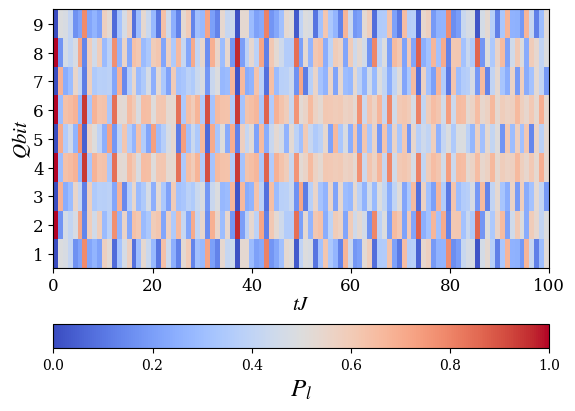

In [68]:
fig, ax= plt.subplots()
im_9= ax.imshow(np.abs(Pi_9), interpolation='nearest', origin='lower',
               cmap=cm.coolwarm, extent=[0, 100, 0.5, 9.5],vmin=0, vmax=1, aspect='auto')

plt.xlabel('$tJ$',fontsize=15, labelpad=0)
plt.ylabel('$Qbit$',fontsize=15, labelpad=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

cbar= fig.colorbar(im_9, orientation='horizontal',  shrink=1)
cbar.set_label('$P_l$',size=18)

plt.show()

## 
$QFI=4 \chi\\
F= |\braket{\phi_0(h)|\phi_0(h+\delta h)}|=1-\frac{1}{2} (\delta h)^2 \chi$

In [6]:
# Unitary time evolution QFI # static Hamiltonian
def MB_timeQFI(N,J,D,h0,d_h0,t,N_t):
    Psi_t = MB_timePsi(N,J,D,h0,t,N_t)
    d_Psi_t = MB_timePsi(N,J,D,h0+d_h0,t,N_t)
    QFI_t= np.zeros(N_t);
    for ti in range(N_t):
        F = np.dot(np.transpose(d_Psi_t[ti]).conj(),Psi_t[ti]);
        QFI_t[ti]= 4*(1-np.abs(F.conj()*F))/ d_h0**2
    return QFI_t


In [80]:
# define the long-time many-body QFI
def MB_QFIh0(N,J,D,H0,d_h0,T,n_h0):       
    
    QFIh0= np.zeros((n_h0))
    for i_h0 in range(n_h0):
        # print('i_h0=',i_h0)

        H= MB_hamiltonian(N,J,D,H0[i_h0])
        d_H= MB_hamiltonian(N,J,D,H0[i_h0]+d_h0)

        Psi_T= np.dot(expm(-1j*H*T),Psi_0_t);
        d_Psi_T= np.dot(expm(-1j*d_H*T),Psi_0_t);

        F= np.dot(np.transpose(Psi_T).conj(),d_Psi_T);
        QFIh0[i_h0]=  4*(1-np.abs(F.conj()*F))/d_h0**2
    return QFIh0

In [15]:
n_site= 11;
Num= np.array([
      10, 11, 12, 13, 14
      , 15, 16, 17, 18, 19, 20
      ])

n0=np.linspace(0,.009,10); n1=np.linspace(.01,.1,10); n2= np.linspace(.15,.5,8);n3= np.linspace(.52,1,25);
n4= np.linspace(2,5,4);
H0= np.zeros(57);H0[0:10]=n0; H0[10:20]= n1; H0[20:28]= n2; H0[28:53]=n3; H0[53:57]= n4;
n_h0= 57

d_h0= .0001

####
half filling

In [11]:
# Psi_0_even= |01010101>
Up= np.array([[1],[0]])
Down= np.array([[0],[1]])
Psi_0_t = 1;

for j in range(1,N,2):
    Psi_0_t= np.kron(Psi_0_t,Down)
    Psi_0_t= np.kron(Psi_0_t,Up)

In [16]:
J=-1; D= 0; T= 500;
QFIh0N_half_0 = np.zeros((n_site,n_h0))
for nu in range(0,n_site):
    # Psi_0_even= |01010101>
    Up= np.array([[1],[0]])
    Down= np.array([[0],[1]])
    Psi_0_t = 1;
    for j in range(1,N,2):
        Psi_0_t= np.kron(Psi_0_t,Down)
        Psi_0_t= np.kron(Psi_0_t,Up)

    QFIh0N_half_0[nu,:]= MB_QFIh0(Num[nu],J,D,H0,d_h0,T,n_h0)

In [26]:
def fitting(x,a,b):
    return a* x**b 
x_fit = H0[54:n_h0];
fitplot , _ = curve_fit(fitting,x_fit,MB_QFIh0N[10,54:n_h0]);
a,b= fitplot
print(a,b)

17519749.941963047 -1.958611044794123


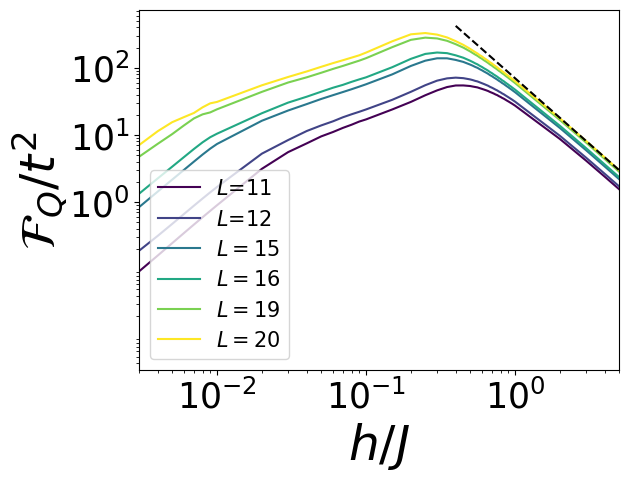

In [28]:
colors = plt.colormaps.get_cmap('viridis').resampled(21).colors

fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

# plt.plot(H0,MB_QFIh0N[0,:]/T**2, label='L=10', color=colors[0])
plt.plot(H0,MB_QFIh0N[1,:]/T**2, label='$L$=11', color=colors[0])
plt.plot(H0,MB_QFIh0N[2,:]/T**2, label='$L$=12', color=colors[4])
# plt.plot(H0,MB_QFIh0N[3,:]/T**2, label='$L=13', color=colors[6])
# plt.plot(H0,MB_QFIh0N[4,:]/T**2, label='$L=14$', color=colors[8])
plt.plot(H0,MB_QFIh0N[5,:]/T**2, label='$L=15$', color=colors[8])
plt.plot(H0,MB_QFIh0N[6,:]/T**2, label='$L=16$', color=colors[12])
# plt.plot(H0,MB_QFIh0N[7,:]/T**2, label='$L=17$', color=colors[14])
# plt.plot(H0,MB_QFIh0N[8,:]/T**2, label='$L=18$', color=colors[16])
plt.plot(H0,MB_QFIh0N[9,:]/T**2, label='$L=19$', color=colors[16])
plt.plot(H0,MB_QFIh0N[10,:]/T**2, label='$L=20$', color=colors[20])

x_fit = np.array(H0[25:n_h0]);
plt.plot(x_fit,a* x_fit**b/T**2,'--',color='k')

plt.xscale('log')
plt.yscale('log')
plt.xlim(.003,5)

# Naming the x-axis, y-axis 1and the whole graph
plt.xlabel("$h/J$",fontsize=35)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=35, labelpad= 0)
axes1.set_yticks([1, 10, 100])                      
axes1.set_yticklabels(['$10^0$','$10^1$','$10^2$']) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc='lower left', fontsize= '15')

plt.show()


In [29]:
# Maximum of the QFI
MaxMB_QFIh0N= [max(MB_QFIh0N[0,:]), max(MB_QFIh0N[1,:]), max(MB_QFIh0N[2,:]), max(MB_QFIh0N[3,:])
            , max(MB_QFIh0N[4,:]), max(MB_QFIh0N[5,:]), max(MB_QFIh0N[6,:]), max(MB_QFIh0N[7,:])
            , max(MB_QFIh0N[8,:]), max(MB_QFIh0N[9,:]), max(MB_QFIh0N[10,:])
            ]

In [30]:
# fitting the Maximum of the QFI 
def fitting(x,a,b):
    return a* x**b 
x_fit = Num
fitplot , _ = curve_fit(fitting,x_fit,np.array(MaxMB_QFIh0N)/T**2);
aNMax,bNMax = fitplot
print(aNMax,bNMax)

0.0415837787116788 2.9964336228541018


In [31]:
exMB_QFIh0N= [(MB_QFIh0N[0,17]), (MB_QFIh0N[1,17]), (MB_QFIh0N[2,17]), (MB_QFIh0N[3,17])
            , (MB_QFIh0N[4,17]), (MB_QFIh0N[5,17]), (MB_QFIh0N[6,17]), (MB_QFIh0N[7,17])
            , (MB_QFIh0N[8,17]), (MB_QFIh0N[9,17]), (MB_QFIh0N[10,17])
            ]

In [32]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num
fitplot , _ = curve_fit(fitting,x_fit,np.array(exMB_QFIh0N)/T**2);
aNex,bNex = fitplot
print(aNex,bNex)

0.0017013192240220205 3.7840053205623954


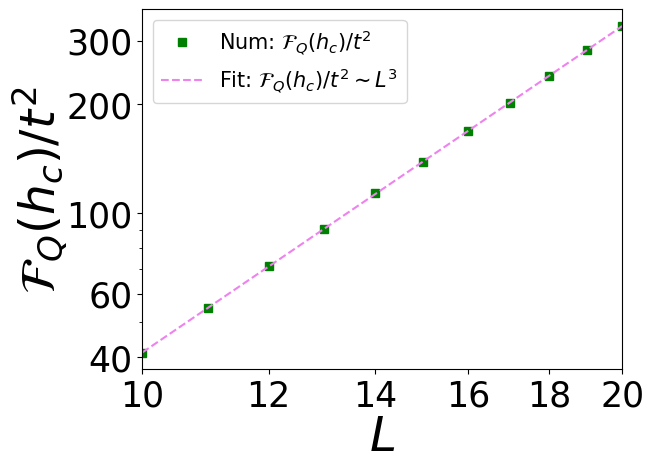

In [34]:
fig= plt.figure()
axes2= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes2.plot(Num, np.array(MaxMB_QFIh0N)/T**2,'s',color='green',label='Num: $\mathcal{F}_{Q}(h_{c})/t^2$')
x_fit = np.array(Num);
plt.plot(x_fit,aNMax* x_fit**bNMax, '--', color='violet', label='Fit: $\mathcal{F}_{Q}(h_{c})/t^2\\sim L^{3}$' )

# axes2.plot(Num, np.array(exMB_QFIh0N)/T**2,'^',color='blue',label='Num: $\mathcal{F}_{Q}(h_{tr})/t^2$')
# x_fit = np.array(Num);
# plt.plot(x_fit,aNex* x_fit**bNex, '--', color='red', label='Fit: $\mathcal{F}_{Q}(h_{tr})/t^2\\propto L^{3}$' )

plt.xscale('log')
plt.yscale('log')
plt.xlim(10,20)
axes2.set_xticks([10, 12, 14, 16, 18, 20])                      
axes2.set_xticklabels([10, 12, 14, 16, 18, 20])
axes2.set_yticks([40, 60, 100, 200,300])                      
axes2.set_yticklabels([40, 60, 100, 200,300]) 

plt.xlabel("$L$",fontsize=35, labelpad=0)
plt.ylabel("$\mathcal{F}_{Q}(h_{c})/t^2$", fontsize=35, labelpad=-2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

axes2.legend(loc='upper left', fontsize='15')

# plt.savefig("MaxMB_QFI-N_1.pdf", format="pdf")

####
Partial Filling


In [ ]:
J=-1; D= 0; T= 500;
MB_XXZ_QFIh0N_pf3 = np.zeros((n_site,n_h0))
for nu in range(0,n_site):
    # Psi_0_partial= |...0101010...>
    Up= np.array([[1],[0]])
    Down= np.array([[0],[1]])
    Psi_0_t = 1;
    for j in range(0,N):
    if j==(N-1)/2 or j==(N-1)/2-2 or j==(N-1)/2+2:
        Psi_0_t= np.kron(Psi_0_t,Up)
        print(j)
    else:
        Psi_0_t= np.kron(Psi_0_t,Down)

    MB_XXZ_QFIh0N_pf3[nu,:]= MB_QFIh0(Num[nu],J,D,H0,d_h0,T,n_h0)

In [48]:
def fitting(x,a,b):
    return a* x**b 
x_fit = H0[52:56];
fitplot , _ = curve_fit(fitting,x_fit,MB_XXZ_QFIh0N_pf3[8,52:56]);
a,b= fitplot
print(a,b)

5965518.938648597 -1.9961510360483663


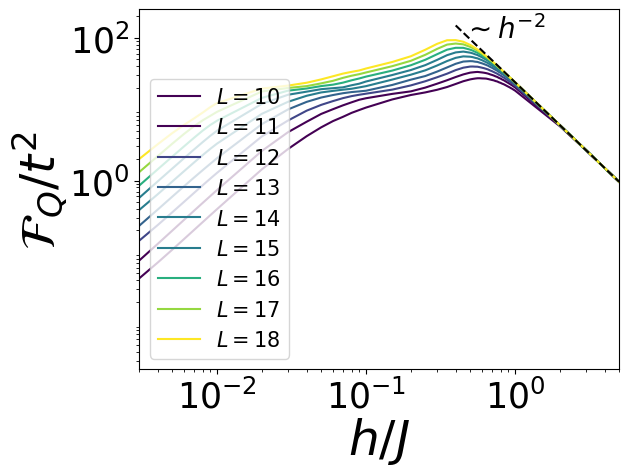

In [49]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(H0,MB_XXZ_QFIh0N_pf3[0,:]/T**2, label='$L=10$', color= colors[0])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[1,:]/T**2, label='$L=11$', color= colors[0])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[2,:]/T**2, label='$L=12$', color= colors[4])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[3,:]/T**2, label='$L=13$', color= colors[6])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[4,:]/T**2, label='$L=14$', color= colors[8])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[5,:]/T**2, label='$L=15$', color= colors[8])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[6,:]/T**2, label='$L=16$', color= colors[12])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[7,:]/T**2, label='$L=17$', color= colors[16])
plt.plot(H0,MB_XXZ_QFIh0N_pf3[8,:]/T**2, label='$L=18$', color= colors[19])
x_fit = np.array(H0[25:n_h0]);
plt.plot(x_fit,a* x_fit**b/T**2,'--',color='k')
plt.text(0.45, 100, '$\sim h^{-2}$', fontsize='20')


plt.xscale('log')
plt.yscale('log')
plt.xlim(.003,5)
# axes1.set_xticks([.1, 1])                      
# axes1.set_xticklabels(['$10^{-1}$', '$10^0$'])
axes1.set_yticks([1,100])                      
axes1.set_yticklabels(['$10^0$','$10^{2}$'])

# Naming the x-axis, y-axis 1and the whole graph
plt.xlabel("$h/J$",fontsize=35, labelpad=0)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=35, labelpad=0)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(loc='lower left', fontsize= '15')

plt.show()

#####
$\mathcal{F}_{Q}-\Delta$

In [15]:
# after simulation of the QFI for different excitations and interaction strength \Delta
Nex= np.array([1,2,3,4,5,6,7,8,9])
Nex2= np.array([1,3,5,7,9])

XXZpm_QFIh017pfN_0_max= np.array([max(XXZpm_QFIh017pf1_0), max(XXZpm_QFIh017pf2_0), max(XXZpm_QFIh017pf3_0)
                                  ,max(XXZpm_QFIh017pf4_0), max(XXZpm_QFIh017pf5_0), max(XXZpm_QFIh017pf6_0)
                                  ,max(XXZpm_QFIh017pf7_0), max(XXZpm_QFIh017pf8_0), max(XXZpm_QFIh017pf9_0)
                                   ])
XXZpm_QFIh017pfN_25_max= np.array([max(XXZpm_QFIh017pf1_25), max(XXZpm_QFIh017pf2_25), max(XXZpm_QFIh017pf3_25)
                                  ,max(XXZpm_QFIh017pf4_25), max(XXZpm_QFIh017pf5_25), max(XXZpm_QFIh017pf6_25)
                                  ,max(XXZpm_QFIh017pf7_25), max(XXZpm_QFIh017pf8_25), max(XXZpm_QFIh017pf9_25)
                                   ])
XXZpm_QFIh017pfN_5_max= np.array([max(XXZpm_QFIh017pf1_5), max(XXZpm_QFIh017pf2_5), max(XXZpm_QFIh017pf3_5)
                                  ,max(XXZpm_QFIh017pf4_5), max(XXZpm_QFIh017pf5_5), max(XXZpm_QFIh017pf6_5)
                                  ,max(XXZpm_QFIh017pf7_5), max(XXZpm_QFIh017pf8_5), max(XXZpm_QFIh017pf9_5)
                                   ])
XXZpm_QFIh017pfN_75_max= np.array([max(XXZpm_QFIh017pf1_75), max(XXZpm_QFIh017pf3_75), max(XXZpm_QFIh017pf5_75),max(XXZpm_QFIh017pf7_75), max(XXZpm_QFIh017pf9_75)
                                   ])
XXZpm_QFIh017pfN_10_max= np.array([max(XXZpm_QFIh017pf1_10), max(XXZpm_QFIh017pf3_10), max(XXZpm_QFIh017pf5_10),max(XXZpm_QFIh017pf7_10), max(XXZpm_QFIh017pf9_10)
                                   ])

In [ ]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Nex[0:7];
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_0_max[0:7]));
aAlpha_0,bAlpha_0 = fitplot
# print(bAlpha_0)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_25_max[0:7]));
aAlpha_25,bAlpha_25 = fitplot
# print(bAlpha_25)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_5_max[0:7]));
aAlpha_5,bAlpha_5 = fitplot
# print(bAlpha_5)
x_fit = Nex2[0:3];
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_75_max[0:3]));
aAlpha_75,bAlpha_75 = fitplot
# print(bAlpha_75)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_10_max[0:3]));
aAlpha_10,bAlpha_10 = fitplot
# print(bAlpha_10)

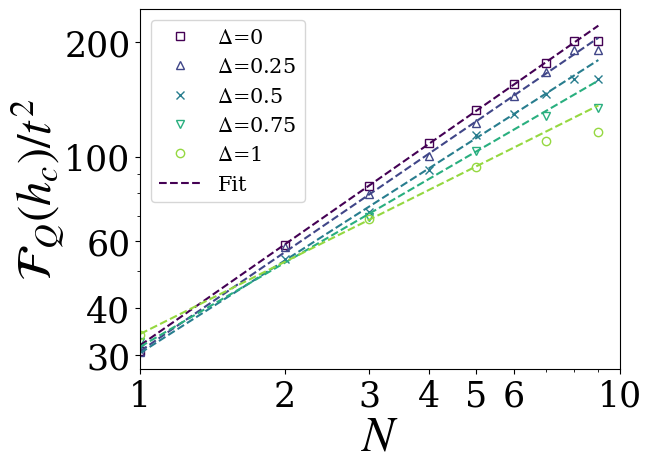

In [18]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes1.plot(Nex,XXZpm_QFIh017pfN_0_max/T**2,'s',markerfacecolor='none', label='$\Delta$=0', color=colors[0])
axes1.plot(Nex,XXZpm_QFIh017pfN_25_max/T**2,'^',markerfacecolor='none', label='$\Delta$=0.25', color=colors[4])
axes1.plot(Nex,XXZpm_QFIh017pfN_5_max/T**2,'x',markerfacecolor='none', label='$\Delta$=0.5', color=colors[8])
axes1.plot(Nex2,XXZpm_QFIh017pfN_75_max/T**2,'v',markerfacecolor='none', label='$\Delta$=0.75', color=colors[12])
axes1.plot(Nex2,XXZpm_QFIh017pfN_10_max/T**2,'o',markerfacecolor='none', label='$\Delta$=1', color=colors[16])

x_fit= Nex
plt.plot(x_fit,aAlpha_0* x_fit**bAlpha_0/T**2,'--', label='Fit',color=colors[0] )
plt.plot(x_fit,aAlpha_25* x_fit**bAlpha_25/T**2,'--',color=colors[4])
plt.plot(x_fit,aAlpha_5* x_fit**bAlpha_5/T**2,'--',color=colors[8])
plt.plot(x_fit,aAlpha_75* x_fit**bAlpha_75/T**2,'--',color=colors[12])
plt.plot(x_fit,aAlpha_10* x_fit**bAlpha_10/T**2,'--',color=colors[16])

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,10)
axes1.set_xticks([1,2,3,4, 5,6,10])    
axes1.set_yticks([30, 40, 60, 100, 200])                      

# Naming the x-axis, y-axis 1and the whole graph
plt.xlabel("$N$",fontsize=35, labelpad=0)
plt.ylabel("$\mathcal{F}_{Q}(h_{c})/t^2$", fontsize=35, labelpad=-2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
axes1.legend(loc='upper left', fontsize= '15')

plt.show()


In [54]:
# the many-body QFI in the localized phase

XXZpm_QFIh017pfN_0_loc= np.array([(XXZpm_QFIh017pf1_0[56]), (XXZpm_QFIh017pf2_0[56]), (XXZpm_QFIh017pf3_0[56]), 
                                   (XXZpm_QFIh017pf4_0[56]), (XXZpm_QFIh017pf5_0[56]), (XXZpm_QFIh017pf6_0[56]), 
                                   (XXZpm_QFIh017pf7_0[56]), (XXZpm_QFIh017pf8_0[56]), (XXZpm_QFIh017pf9_0[56])
                                   ])
XXZpm_QFIh017pfN_25_loc= np.array([(XXZpm_QFIh017pf1_25[56]), (XXZpm_QFIh017pf2_25[56]), (XXZpm_QFIh017pf3_25[56]), 
                                   (XXZpm_QFIh017pf4_25[56]), (XXZpm_QFIh017pf5_25[56]), (XXZpm_QFIh017pf6_25[56]), 
                                   (XXZpm_QFIh017pf7_25[56]), (XXZpm_QFIh017pf8_25[56]), (XXZpm_QFIh017pf9_25[56])
                                   ])
XXZpm_QFIh017pfN_5_loc= np.array([(XXZpm_QFIh017pf1_5[56]), (XXZpm_QFIh017pf2_5[56]), (XXZpm_QFIh017pf3_5[56]), 
                                   (XXZpm_QFIh017pf4_5[56]), (XXZpm_QFIh017pf5_5[56]), (XXZpm_QFIh017pf6_5[56]), 
                                   (XXZpm_QFIh017pf7_5[56]), (XXZpm_QFIh017pf8_5[56]), (XXZpm_QFIh017pf9_5[56])
                                   ])
XXZpm_QFIh017pfN_75_loc= np.array([(XXZpm_QFIh017pf1_75[56]), (XXZpm_QFIh017pf2_75[56]), (XXZpm_QFIh017pf3_75[56]), 
                                   (XXZpm_QFIh017pf4_75[56]), (XXZpm_QFIh017pf5_75[56]), (XXZpm_QFIh017pf6_75[56]), 
                                   (XXZpm_QFIh017pf7_75[56]), (XXZpm_QFIh017pf8_75[56]), (XXZpm_QFIh017pf9_75[56])
                                   ])
XXZpm_QFIh017pfN_10_loc= np.array([(XXZpm_QFIh017pf1_10[56]), (XXZpm_QFIh017pf2_10[56]), (XXZpm_QFIh017pf3_10[56]), 
                                   (XXZpm_QFIh017pf4_10[56]), (XXZpm_QFIh017pf5_10[56]), (XXZpm_QFIh017pf6_10[56]), 
                                   (XXZpm_QFIh017pf7_0[56]), (XXZpm_QFIh017pf8_10[56]), (XXZpm_QFIh017pf9_10[56])
                                   ])

In [55]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Nex[0:7];
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_0_loc[0:7]));
aAlphal_0,bAlphal_0 = fitplot
# print(bAlpha_0)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_25_loc[0:7]));
aAlphal_25,bAlphal_25 = fitplot
# print(bAlpha_25)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_5_loc[0:7]));
aAlphal_5,bAlphal_5 = fitplot
# print(bAlpha_5)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_75_loc[0:7]));
aAlphal_75,bAlphal_75 = fitplot
# print(bAlpha_75)
fitplot , _ = curve_fit(fitting,x_fit,np.array(XXZpm_QFIh017pfN_10_loc[0:7]));
aAlphal_10,bAlphal_10 = fitplot
# print(bAlpha_10)

In [184]:
Del= [0,.25,.5,.75,1]; 
Alpha= [bAlpha_0, bAlpha_25, bAlpha_5, bAlpha_75, bAlpha_10]
AlphaLoc= [bAlphal_0, bAlphal_25, bAlphal_5, bAlphal_75, bAlphal_10]

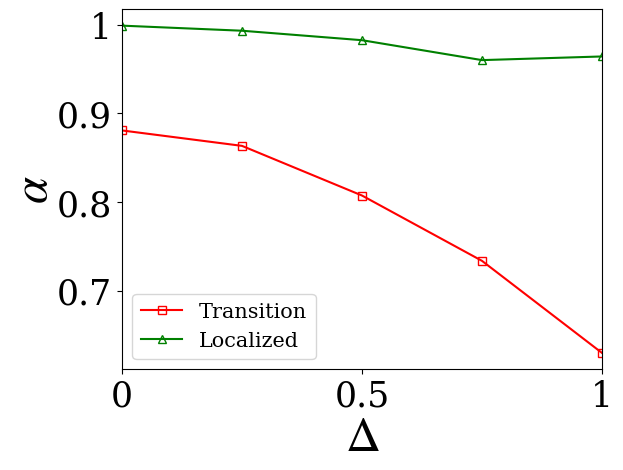

In [185]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes1.plot(Del,Alpha,'s-',markerfacecolor='none', color='r', label= 'Transition')
axes1.plot(Del,AlphaLoc,'^-',markerfacecolor='none', color='g', label= 'Localized' )

plt.xlim(0,1)
axes1.set_xticks([0, 0.5, 1])                      
axes1.set_xticklabels([0, 0.5,1]) 
axes1.set_yticks([0.7, 0.8, 0.9,1])                      
axes1.set_yticklabels([0.7, 0.8, 0.9,1])

plt.xlabel('$\Delta$',fontsize=35, labelpad=0)
plt.ylabel('$\\alpha$',fontsize=35, labelpad=0)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

axes1.legend(loc='lower left', fontsize= '15')

plt.show()

In [10]:
# the many-body QFI as a function of L for the excitation N=3
Num= [10,11,12,13,14,15,16,17,18]
MaxMB_XXZ_QFIh0N_pf3= [max(MB_XXZ_QFIh0N_pf3[0,:]),max(MB_XXZ_QFIh0N_pf3[1,:])
            , max(MB_XXZ_QFIh0N_pf3[2,:]), max(MB_XXZ_QFIh0N_pf3[3,:])
            ,max(MB_XXZ_QFIh0N_pf3[4,:]),max(MB_XXZ_QFIh0N_pf3[5,:])
            , max(MB_XXZ_QFIh0N_pf3[6,:]), max(MB_XXZ_QFIh0N_pf3[7,:]),  max(MB_XXZ_QFIh0N_pf3[8,:])
            ]

In [11]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num
fitplot , _ = curve_fit(fitting,x_fit,np.array(MaxMB_XXZ_QFIh0N_pf3)/T**2);
aNMax,bNMax = fitplot
print(aNMax,bNMax)

0.13405557754300562 2.1642737527017286


In [38]:
exMB_QFIh0N_pf3= [(MB_XXZ_QFIh0N_pf3[0,3]), (MB_XXZ_QFIh0N_pf3[1,3]), (MB_XXZ_QFIh0N_pf3[2,3]), (MB_XXZ_QFIh0N_pf3[3,3])
            , (MB_XXZ_QFIh0N_pf3[4,3]), (MB_XXZ_QFIh0N_pf3[5,3]), (MB_XXZ_QFIh0N_pf3[6,3]), (MB_XXZ_QFIh0N_pf3[7,3])
            , (MB_XXZ_QFIh0N_pf3[8,3])
            ]

In [66]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num
fitplot , _ = curve_fit(fitting,x_fit,np.array(exMB_QFIh0N_pf3)/T**2);
aNex,bNex = fitplot
print(aNex,bNex)

5.261347687155089e-09 6.831171787751245


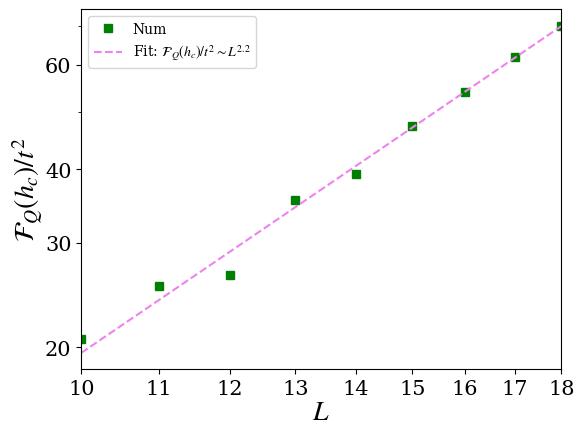

In [12]:
fig= plt.figure()
axes2= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes2.plot(Num, np.array(MaxMB_XXZ_QFIh0N_pf3)/T**2,'s',color='green',label='Num')
x_fit = np.array(Num);
plt.plot(x_fit,aNMax* x_fit**bNMax, '--', color='violet', label='Fit: $\mathcal{F}_{Q}(h_{c})/t^2\\sim L^{2.2}$' )

plt.xscale('log')
plt.yscale('log')
plt.xlim(10,18)
axes2.set_xticks([10,11, 12, 13, 14, 15, 16, 17,18])                      
axes2.set_xticklabels([10,11, 12, 13, 14, 15, 16, 17,18]) 
axes2.set_yticks([20,30,40,60])                      
axes2.set_yticklabels([20,30,40,60])

plt.xlabel("$L$",fontsize=20, labelpad=0)
plt.ylabel("$\mathcal{F}_{Q}(h_{c})/t^2$", fontsize=20, labelpad=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

axes2.legend(loc='upper left', fontsize='10')

plt.show()

## CFI
$F_C=\sum_k \frac{1}{P_k} (\frac{\partial P_k}{\partial h})^2$ 

In [51]:
# Unitary time evolution CFI 
def MB_timeCFI(N,J,h0,d_h0,t,N_t):
    Psi_t = MB_timePsi(N,J,D,h0,t,N_t)
    d_Psi_t = MB_timePsi(N,J,D,h0+d_h0,t,N_t)
    CFI_t= np.zeros(N_t);
    for ti in range(N_t):
        for pi in range(N_p):
            P= np.dot(np.transpose(Eigen[pi]).conj(),Psi_t[ti])
            P2= P.conj()*P
            d_P= np.dot(np.transpose(Eigen[pi]).conj(),d_Psi_t[ti])
            d_P2= d_P.conj()*d_P
            devP= (d_P2-P2)/d_h0 

            # print(1/P *devP.conj()* devP)

            CFI_t[ti]+= abs(1/P2 *devP.conj()* devP)
    return CFI_t

In [67]:
N= 6
N_t= 100
t= np.linspace(1,100,N_t); 

In [53]:
# Psi_0_even= |01010101>
Up= np.array([[1],[0]])
Down= np.array([[0],[1]])
Psi_0_t = 1;

for j in range(1,N,2):
    Psi_0_t= np.kron(Psi_0_t,Down)
    Psi_0_t= np.kron(Psi_0_t,Up)

In [56]:
# Permutation of excitation
N=6
p=[]
for i in distinct_permutations([1,1,1,0,0,0]):
    p.append(i)
    # print(i)
N_p= np.shape(p)[0]
print(N_p)

Up= np.array([[1],[0]])
Down= np.array([[0],[1]])
Eigen= []; 
for pi in range(N_p):
    E = 1;
    for j in range(0,N):
        if p[pi][j]==1:  
            E= np.kron(E,Up)
            # print('1')
        else:
            E= np.kron(E,Down)
            # print('0')
    Eigen.append(E)
# print(Eigen)

20


In [96]:
# For comparing the CFI with the QFI 
n0=np.linspace(0,.009,10); n1=np.linspace(.01,.1,10); n2= np.linspace(.15,.5,8);n3= np.linspace(.52,1,25);
n4= np.linspace(2,5,4);
H0= np.zeros(57);H0[0:10]=n0; H0[10:20]= n1; H0[20:28]= n2; H0[28:53]=n3; H0[53:57]= n4;
n_h0= 57

#For comparing dh Baysian estimation with Cramer-Rao bound
# H0= np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
# n_h0= 10;

d_h0= .00000001

In [93]:
MB_CFIh06 = np.zeros(n_h0)
for el0 in range(0,n_h0):
    CFI_t= MB_timeCFI(N,J,H0[el0],d_h0,t,N_t)
    MB_CFIh06[el0]= np.mean(CFI_t[10:]/t[10:]**2)
    # print('n_h0=',el0)

In [94]:
QFIh06_half_0= MB_QFIh0(N,J,D,H0,d_h0,T,n_h0)

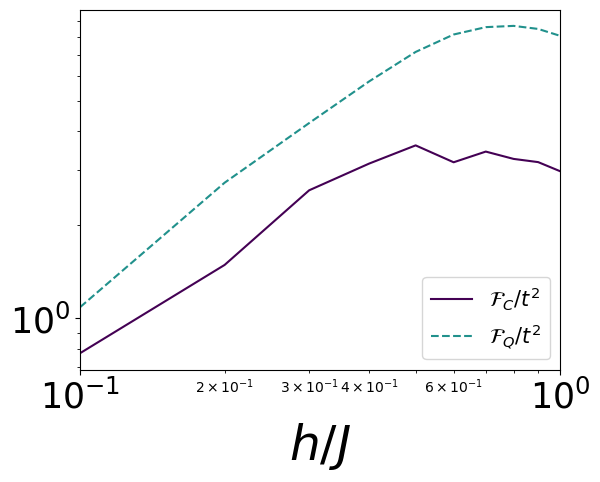

In [95]:
colors = plt.colormaps.get_cmap('viridis').resampled(21).colors

fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(H0,MB_CFIh06, '-', label='$\mathcal{F}_{C}/t^2$', color=colors[0])
plt.plot(H0,QFIh06_half_0/T**2, '--', label='$\mathcal{F}_{Q}/t^2$', color=colors[10])

plt.xscale('log')
plt.yscale('log')
plt.xlim(.1,1)

# Naming the x-axis, y-axis 1and the whole graph
plt.xlabel("$h/J$",fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc='lower right', fontsize= '15')

plt.show()


## Beyasian

In [15]:
def MB_time_Bayesian(N,J,h0,n_h0,h0_es,M):

    # Psi_0_even= |01010101>
    Up= np.array([[1],[0]])
    Down= np.array([[0],[1]])
    Psi_0_t = 1;
    for j in range(1,N,2):
        Psi_0_t= np.kron(Psi_0_t,Down)
        Psi_0_t= np.kron(Psi_0_t,Up)


    p=np.zeros((N_p,n_h0));
    for i_h in range(n_h0):
        H= MB_hamiltonian(N,J,D,h0[i_h])
        Psi_t= np.dot(expm(-1j*H*T),Psi_0_t);
        for i_p in range(N_p):
            c= np.dot(np.transpose(Eigen[i_p]).conj(),Psi_t)
            p[i_p,i_h]= abs(c.conj()*c)

    
    H= MB_hamiltonian(N,J,D,h0_es);
    Psi_t_es= np.dot(expm(-1j*H*T),Psi_0_t);            
    p_es= np.zeros(N_p)
    for i_p in range(N_p):
        c= np.dot(np.transpose(Eigen[i_p]).conj(),Psi_t_es)
        p_es[i_p]= abs(c.conj()*c)
    # print(p_es)

    
    max_M= []; mean_M= []; var_M= [];
    for n in range(100):
        # Measurement of Lattice     
        n_l= np.zeros(N_p)
        for i_m in range(M):
            r= choice(N_p,1,p=p_es)
            n_l[r]+= 1
        #print(n_l)

        One= np.ones(n_h0);
        P_h0= np.ones(n_h0) / n_h0
        likelihood=One;
        for i_N in range(N):
            likelihood= likelihood * binom(M,n_l[i_N]) * p[i_N,:]**n_l[i_N]
        # print(likelihood)

        evidence = np.sum(likelihood * P_h0 * dh0)
        P_h0= likelihood*P_h0/evidence
        # print(evidence)

        Mean= sum(h0[i_h] * P_h0[i_h] * dh0 for i_h in range(n_h0))
        Var= sum((h0[i_h]-Mean)**2 * P_h0[i_h] * dh0 for i_h in range(n_h0))
               
        mean_M.append(Mean)
        var_M.append(Var)

        max_M.append(np.argmax(P_h0))

    muMax= np.mean(np.mean(h0[max_M]))
    varMax= np.var(h0[max_M])

    mu= np.mean(mean_M)
    var= np.mean(var_M)
    
    return mu, var, muMax , varMax


In [16]:
J=-1; D=0;
T=100; delta_t= 1;  N_t= int(T/delta_t)
t=np.linspace(1,T,N_t)

In [17]:
# Permutation of excitation
N=6
p=[]
for i in distinct_permutations([1,1,1,0,0,0]):
    p.append(i)
    # print(i)
N_p= np.shape(p)[0]
print(N_p)

Up= np.array([[1],[0]])
Down= np.array([[0],[1]])
Eigen= []; 
for pi in range(N_p):
    E = 1;
    for j in range(0,N):
        if p[pi][j]==1:  
            E= np.kron(E,Up)
            # print('1')
        else:
            E= np.kron(E,Down)
            # print('0')
    Eigen.append(E)
# print(Eigen)

20


In [72]:
n_es= 46
h0_es= np.linspace(.1,1,n_es)
M=100;
print('M= ',M);
mu_h0= []; muMax_h0= []; var_h0= []; varMax_h0= []
for i_hes in range(0,n_es):   

    n_h0_b= 11
    h0_b= np.linspace(h0_es[i_hes]-.005, h0_es[i_hes]+.005,n_h0_b)
    dh0= h0_b[1]-h0_b[0]

    mu, var, muMax, varMax= MB_time_Bayesian(N,J,h0_b,n_h0_b,h0_es[i_hes],M)
    
    mu_h0.append(mu)
    var_h0.append(np.mean(var))
    muMax_h0.append(muMax)
    varMax_h0.append(varMax)

In [62]:
var_h0_100= var_h0
varMax_h0_100= varMax_h0
mu_100= mu_h0
muMax_100= muMax_h0

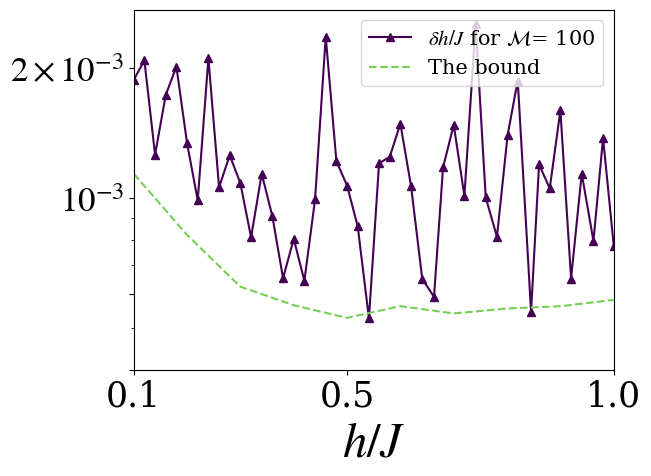

In [63]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()# plt.plot(h0_es_d, var_h0_d_100, '^-', label= '$\mathcal{M}$= 100', color= colors[0])

axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(h0_es, np.sqrt(var_h0_100), '^-', label= '$\delta h/J$ for $\mathcal{M}$= 100', color= colors[0])
plt.plot(H0,1/np.sqrt(100*MB_CFIh06*T**2), '--', color= colors[15], label= 'The bound')

plt.yscale('log')
plt.xlim(.1,1)

plt.xlabel("$h/J$",fontsize=35)
axes1.set_xticks([.1, .5, 1])
axes1.set_yticks([4e-4, 6e-4, 1e-3, 2e-3])
axes1.set_yticklabels(['','','$10^{-3}$', '$2 \\times 10^{-3}$'])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(loc='upper right', fontsize= '15')

plt.show()


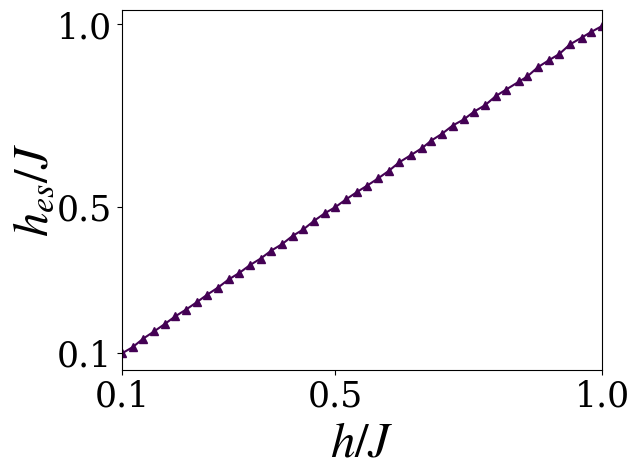

In [65]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(h0_es, muMax_100, '^-', markevery=1, color= colors[0])
plt.xlim(.1,1)

plt.xlabel("$h/J$",fontsize=35)
plt.ylabel("$h_{es}/J$", fontsize=35, labelpad= 0)

axes1.set_yticks([.1,.5, 1])
axes1.set_xticks([.1, .5, 1])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()


## Decoherence
$ \mathcal{F}_{Q}(h)= 2 \sum_{nm} \frac{\braket{\Psi_m|\partial_h \rho_h|\Psi_n}}{\rho_n +\rho_m}$ 

In [7]:
# calculation the QFI under the enfluence of the decoherence
def QLindbladQFI(N,J,h0,t,gamma):
    # Psi_0_even_half
    Up= basis(2,0)
    Down= basis(2,1)
    Psi_0_t= Down
    for j in range(1,N-1,2):
        Psi_0_t= tensor(Psi_0_t,Up)
        Psi_0_t= tensor(Psi_0_t,Down)
    Psi_0_t= tensor(Psi_0_t,Up)

    H, C= QMB_hamiltonian(N, J, D, h0)
    results= mesolve(H,Psi_0_t,t,C,[])
    rho_t= results.states
    d_H, C= QMB_hamiltonian(N, J, D, h0+d_h0)
    results= mesolve(d_H,Psi_0_t,t,C,[])
    d_rho_t= results.states
    Dev_rho_t= (np.array(d_rho_t)-np.array(rho_t))/d_h0

    QFI_t= []; CFI_t= []
    for i_t in range(N_t):

        eigval, eigvec= eigh(rho_t[i_t].full())

        QFI=0; CFI=0
        for n in range(2**N):
            for m in range(2**N):
                if eigval[n]+eigval[m]>=1e-15:
                    QFI+= 2*(abs(np.dot(eigvec[:,m].transpose().conj(), np.dot(Dev_rho_t[i_t].full(), eigvec[:,n]))))**2/(eigval[m]+eigval[n])
    
        QFI_t.append(QFI)

    return rho_t, QFI_t


In [8]:
J = -1; D=0; 
delta_t = .1; T = 100;
N_t= int(T/delta_t+1); t_d=np.linspace(0,T,N_t);

In [99]:
N=6;
d_h0=1e-6;
h0= .5;

gamma=np.sqrt(.005); 
rho_t, QQFI_t_h5_g005= QLindbladQFI(N,J,h0,t_d,gamma)
# gamma=np.sqrt(.01);
# rho_t, QQFI_t_h5_g01= QLindbladQFI(N,J,h0,t_d,gamma)
# gamma=np.sqrt(.05);
# rho_t, QQFI_t_h5_g05= QLindbladQFI(N,J,h0,t_d,gamma)


In [12]:
# Psi_0_even= |01010101>
Up= np.array([[1],[0]])
Down= np.array([[0],[1]])
Psi_0_t = 1;

for j in range(1,N,2):
    Psi_0_t= np.kron(Psi_0_t,Down)
    Psi_0_t= np.kron(Psi_0_t,Up)

In [78]:
d_h0= .00001
h0= .5;
QFI_t_6_half_0_5= MB_timeQFI(N,J,D,h0,d_h0,t_d,N_t)

/tmp/ipykernel_8305/3448633825.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h5_g005/t_d**2, color=colors[0], markevery=100, label='$\gamma/J= 0.005$')
/tmp/ipykernel_8305/3448633825.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h5_g01/t_d**2, color=colors[10], markevery=100, label='$\gamma/J= 0.01$')
/tmp/ipykernel_8305/3448633825.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h5_g05/t_d**2, color=colors[17], markevery=100, label='$\gamma/J= 0.05$')
/tmp/ipykernel_8305/3448633825.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QFI_t_6_half_0_5/t_d**2, '--', color='k', markevery=100, label='$\gamma/J= 0$')


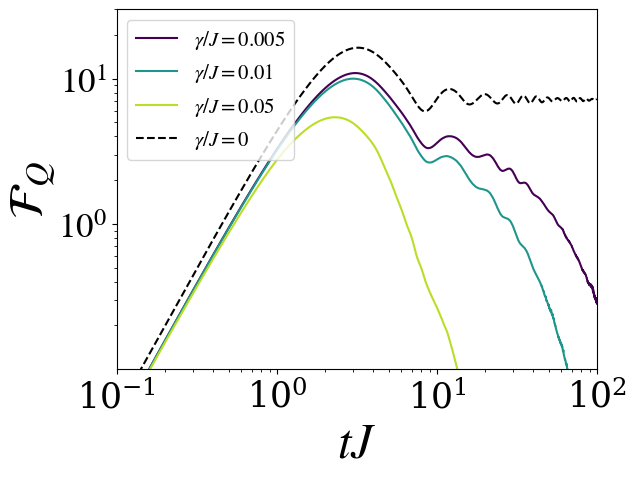

In [102]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(t_d,QQFI_t_h5_g005/t_d**2, color=colors[0], markevery=100, label='$\gamma/J= 0.005$')
plt.plot(t_d,QQFI_t_h5_g01/t_d**2, color=colors[10], markevery=100, label='$\gamma/J= 0.01$')
plt.plot(t_d,QQFI_t_h5_g05/t_d**2, color=colors[17], markevery=100, label='$\gamma/J= 0.05$')

plt.plot(t_d,QFI_t_6_half_0_5/t_d**2, '--', color='k', markevery=100, label='$\gamma/J= 0$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(.1,100)
plt.ylim(.1,30)
plt.xlabel("$tJ$",fontsize=35)
plt.ylabel("$\mathcal{F}_{Q}$", fontsize=35, labelpad= 0)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(loc='upper left', fontsize= '15')

plt.show()


In [17]:
delta_t = 1; T = 200;
N_t= int(T/delta_t+1); t_d=np.linspace(0,T,N_t);

In [18]:
N=6;
d_h0=1e-6;

gamma=np.sqrt(.005)
h0= .5; 
rho_t, QQFI_t_h5_g005= QLindbladQFI(N,J,h0,t_d,gamma)
h0= .7;
rho_t, QQFI_t_h7_g005= QLindbladQFI(N,J,h0,t_d,gamma)
h0= 1;
rho_t, QQFI_t_h10_g005= QLindbladQFI(N,J,h0,t_d,gamma)


/tmp/ipykernel_3125/2688220391.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h5_g005/t_d**2, color=colors[0], markevery=100, label='$h/J= 0.005$')
/tmp/ipykernel_3125/2688220391.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h7_g005/t_d**2, color=colors[10], markevery=100, label='$h/J= 0.01$')
/tmp/ipykernel_3125/2688220391.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h10_g005/t_d**2, color=colors[17], markevery=100, label='$h/J= 0.05$')


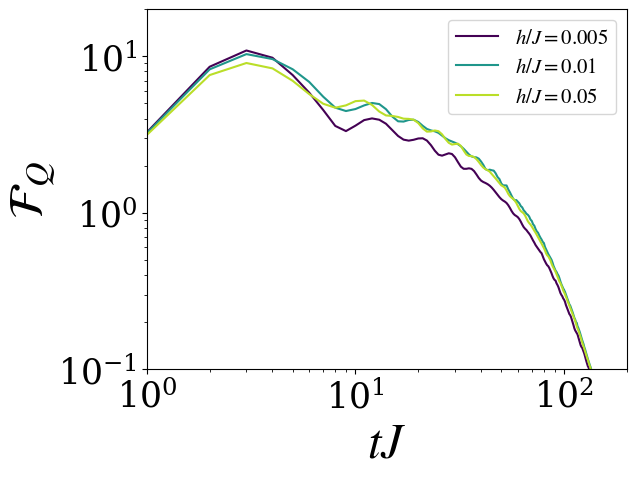

In [20]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(t_d,QQFI_t_h5_g005/t_d**2, color=colors[0], markevery=100, label='$h/J= 0.005$')
plt.plot(t_d,QQFI_t_h7_g005/t_d**2, color=colors[10], markevery=100, label='$h/J= 0.01$')
plt.plot(t_d,QQFI_t_h10_g005/t_d**2, color=colors[17], markevery=100, label='$h/J= 0.05$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,200)
plt.ylim(.1,20)
plt.xlabel("$tJ$",fontsize=35)
plt.ylabel("$\mathcal{F}_{Q}$", fontsize=35, labelpad= 0)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(loc='upper right', fontsize= '15')

plt.show()
